## Vehicle Detection and Tracking Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Step 1: Make a list of image to read in

### 1.1 Import library

In [1]:
import os
import glob

### 1.2 Make a list of image

In [2]:
cars = []
notcars = []
for folder in os.listdir('dataset/vehicles'):
    cars += glob.glob('dataset/vehicles/'+folder+'/*.png')
for folder in os.listdir('dataset/non-vehicles'):
    notcars += glob.glob('dataset/non-vehicles/'+folder+'/*.png')

print('Number of Vehicle Image found:', len(cars))
print('Number of Non Vehicle Image found:', len(notcars))

Number of Vehicle Image found: 8792
Number of Non Vehicle Image found: 8968


## Step 2: Extract Features: color, HOG

### 2.1 Import library

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
import numpy as np
import cv2
from skimage.feature import hog

### 2.2 Import library for visualize progressing

In [4]:
from tqdm import tqdm

### 2.2 Define Functions

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec, 
                                  block_norm='L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell), 
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec, 
                       block_norm='L2-Hys')
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32): #bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to convert color 
def convert_color(image, color_space='YCrCb'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            output_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            output_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            output_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            output_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            output_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            print('Do not support color space:', color_space)
    else:
        output_image = np.copy(image)
    return output_image

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,
                        vis=False):
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion
    feature_image = convert_color(img, color_space)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)

        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    #for file in imgs:
    num_of_imgs = len(imgs)
    for file_id in tqdm(range(num_of_imgs), desc='Extracting'):
        file = imgs[file_id]
        # Read in each one by one
        image = mpimg.imread(file)
        file_features = single_img_features(image, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat,
                        vis=False)
        features.append(file_features)
    # Return list of feature vectors
    return features

# Define a function for plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
        else:
            plt.imshow(img)
        plt.title(titles[i])

### 2.4 Test a Car/NonCar image

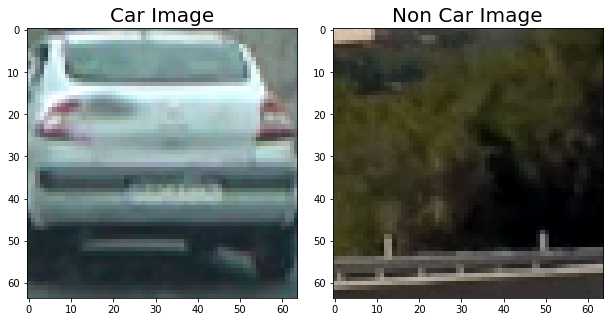

In [6]:
# Choose random car/not-car indices
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car/not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot in notebook
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
f.tight_layout()
ax1.imshow(car_image)
ax1.set_title('Car Image', fontsize=20)
ax2.imshow(notcar_image)
ax2.set_title('Non Car Image', fontsize=20)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.)
# Save to local disk
plt.savefig('output_images/car_noncar_image.png')

### 2.5 Test Extract Feature of single image

#### 2.5.1 Import library for check timing

In [7]:
import time

#### 2.5.2 Test

Using: YCrCb color space 9 orientations 8 pixels per cell 2 cells per block 1 hog channel 32 histogram bins and (32, 32) spatial sampling
0.02 Seconds to extract HOG features of 1 samples


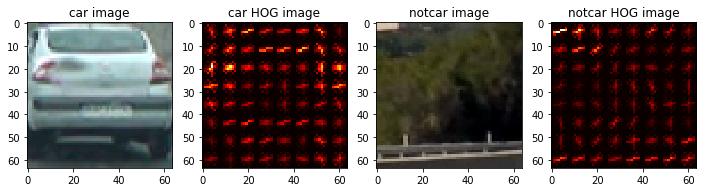

In [8]:
# Define feature parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hog_feat = True # HOG features on or off
hog_channel = 1 # Can be 0, 1, 2, or "ALL"
orient = 9 # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hist_feat = True # Histogram features on or off
hist_bins = 32 # Number of histogram bins
spatial_feat = True # Spatial features on or off
spatial_size = (32, 32) # Spatial binning dimensions

print('Using:', color_space, 'color space',
      orient, 'orientations', pix_per_cell, 'pixels per cell',
      cell_per_block, 'cells per block', hog_channel, 'hog channel',
      hist_bins, 'histogram bins and', spatial_size, 'spatial sampling')

t=time.time()
car_features, car_hog_image = single_img_features(car_image, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
print(round(time.time()-t, 2), 'Seconds to extract HOG features of 1 samples')

notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car HOG image', 'notcar image', 'notcar HOG image']
fig = plt.figure(figsize=(12,3))#, dpi=80)
visualize(fig, 1, 4, images, titles)
# Save to local disk
plt.savefig('output_images/HOG_extraction.png')

## Step 3: Build A Classifier

### 3.1 Extract Feature of all images to prepare for Training

In [9]:
# Define feature parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hog_feat = True # HOG features on or off
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
orient = 9 # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hist_feat = True # Histogram features on or off
hist_bins = 32 # Number of histogram bins
spatial_feat = True # Spatial features on or off
spatial_size = (32, 32) # Spatial binning dimensions

print('Using:', color_space, 'color space',
      orient, 'orientations', pix_per_cell, 'pixels per cell',
      cell_per_block, 'cells per block', hog_channel, 'hog channel',
      hist_bins, 'histogram bins and', spatial_size, 'spatial sampling')

t=time.time()
# Reduce the sample size because HOG features are slow to compute
#sample_size = 4000
#random_idxs = np.random.randint(0, len(cars), sample_size)
test_cars = cars#np.array(cars)[random_idxs]
test_notcars = notcars#np.array(notcars)[random_idxs]

car_features = extract_features(test_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(test_notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print(round(time.time()-t, 2), 'Seconds to extract HOG features of', \
      len(test_cars)+len(test_notcars), 'samples')

Extracting:   0%|          | 13/8792 [00:00<01:07, 129.57it/s]

Using: YCrCb color space 9 orientations 8 pixels per cell 2 cells per block ALL hog channel 32 histogram bins and (32, 32) spatial sampling


Extracting: 100%|██████████| 8968/8968 [01:05<00:00, 136.48it/s]

130.62 Seconds to extract HOG features of 17760 samples


### 3.2 Create Training and Testing dataset

#### 3.2.1 Import library

In [10]:
from sklearn.preprocessing import StandardScaler
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

#### 3.2.2 Create dataset

In [11]:
t=time.time()
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Training data length:', len(y_train))
print('Testing data length:', len(y_test))
print('Feature vector length:', len(X_train[0]))
print(round(time.time()-t, 2), 'Seconds to create dataset')

Training data length: 14208
Testing data length: 3552
Feature vector length: 8460
3.88 Seconds to create dataset


### 3.3 Training with Linear SVC

#### 3.3.1 Import library

In [12]:
from sklearn.svm import LinearSVC

#### 3.3.2 Training

In [13]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

22.7 Seconds to train SVC...


### 3.4 Check the score of the SVC

In [14]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9862


### 3.5 Save Classifier model

#### 3.5.1 Import library to work with pickle file

In [15]:
import pickle

#### 3.5.2 Define functions

In [16]:
def save_model(file, model, scaler, hog_channel, \
               orient, pix_per_cell, cell_per_block, \
               spatial_size, hist_bins, color_space):
    pick = {'model': model,
           'scaler': scaler,
           'hog_channel': hog_channel,
           'orient': orient,
           'pix_per_cell': pix_per_cell,
           'cell_per_block': cell_per_block,
           'spatial_size': spatial_size,
           'hist_bins': hist_bins,
           'color_space': color_space}
    with open(file, 'wb') as f:
        pickle.dump(pick, f)

def load_model(file):
    with open(file, 'rb') as f:
        pick = pickle.load(f)
        model          = pick['model']
        scaler         = pick['scaler']
        hog_channel    = pick['hog_channel']
        orient         = pick['orient']
        pix_per_cell   = pick['pix_per_cell']
        cell_per_block = pick['cell_per_block']
        spatial_size   = pick['spatial_size']
        hist_bins      = pick['hist_bins']
        color_space    = pick['color_space']
    return model, scaler, hog_channel, \
            orient, pix_per_cell, cell_per_block, \
            spatial_size, hist_bins, color_space

#### 3.5.3 Save SVC model

In [17]:
save_model('model.pkl', svc, X_scaler, hog_channel, \
           orient, pix_per_cell, cell_per_block, \
           spatial_size, hist_bins, color_space)

#### 3.5.4 Load SVC model

In [18]:
svc, X_scaler, hog_channel, \
orient, pix_per_cell, cell_per_block, \
spatial_size, hist_bins, color_space = load_model('model.pkl')
print('hog_channel', hog_channel)
print('orient', orient)
print('pix_per_cell', pix_per_cell)
print('cell_per_block', cell_per_block)
print('spatial_size', spatial_size)
print('hist_bins', hist_bins)
print('color_space', color_space)

hog_channel ALL
orient 9
pix_per_cell 8
cell_per_block 2
spatial_size (32, 32)
hist_bins 32
color_space YCrCb


## Step 4: Sliding Windows

### 4.1 Define Functions

In [19]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler,
                    x_start_stop=[None, None], y_start_stop=[None, None], 
                    color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []

    #2) Get image part for extraction
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    img_tosearch = img[y_start_stop[0]:y_start_stop[1],x_start_stop[0]:x_start_stop[1],:] # [height, width, channel]

    #3) Apply color conversion
    img_tosearch = convert_color(img_tosearch, color_space=color_space)

    #4) Extract HOG features of full img_tosearch
    if hog_feat == True:
        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(img_tosearch[:,:,0], orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(img_tosearch[:,:,1], orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(img_tosearch[:,:,2], orient, pix_per_cell, cell_per_block, feature_vec=False)

    #5) Iterate over all windows in the list
    for window in windows:
        #5.1) Define an empty list to receive features
        sample_features = []
        #5.2.1) Extract the image patch
        subimg = img_tosearch[window[0][1]-y_start_stop[0]:window[1][1]-y_start_stop[0], 
                              window[0][0]-x_start_stop[0]:window[1][0]-x_start_stop[0]]
        subimg = cv2.resize(subimg, (64, 64)) # equal line 141 - ori_search_windows
        #5.2.2) Get color features
        if spatial_feat == True:
            spatial_features = bin_spatial(subimg, size=spatial_size)
            sample_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(subimg, nbins=hist_bins) #, bins_range=hist_range)
            sample_features.append(hist_features)
        #5.2.3) HOG feature
        if hog_feat == True:
            sampling_rate = 64
            nblocks_per_window = (sampling_rate // pix_per_cell) - cell_per_block + 1
            xpos = (window[0][0] - x_start_stop[0])//pix_per_cell
            ypos = (window[0][1] - y_start_stop[0])//pix_per_cell

            if hog_channel == 0:
                hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            elif hog_channel == 1:
                hog_features = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            elif hog_channel == 2:
                hog_features = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            elif hog_channel == 'ALL':
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = []
            sample_features.append(hog_features)
        #6) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(np.concatenate(sample_features)).reshape(1, -1))
        #7) Predict using your classifier
        prediction = clf.predict(test_features)
        #8) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)

    #9) Return windows for positive detections
    return on_windows

def ori_search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### 4.2 Test

0.5885422229766846 seconds to process one image searching 155 windows
0.6287741661071777 seconds to process one image searching 155 windows
0.5945758819580078 seconds to process one image searching 155 windows
0.592336893081665 seconds to process one image searching 155 windows
0.6200594902038574 seconds to process one image searching 155 windows
0.5662286281585693 seconds to process one image searching 155 windows
0.5683867931365967 seconds to process one image searching 155 windows
0.597402811050415 seconds to process one image searching 155 windows
0.5990843772888184 seconds to process one image searching 155 windows
0.596804141998291 seconds to process one image searching 155 windows


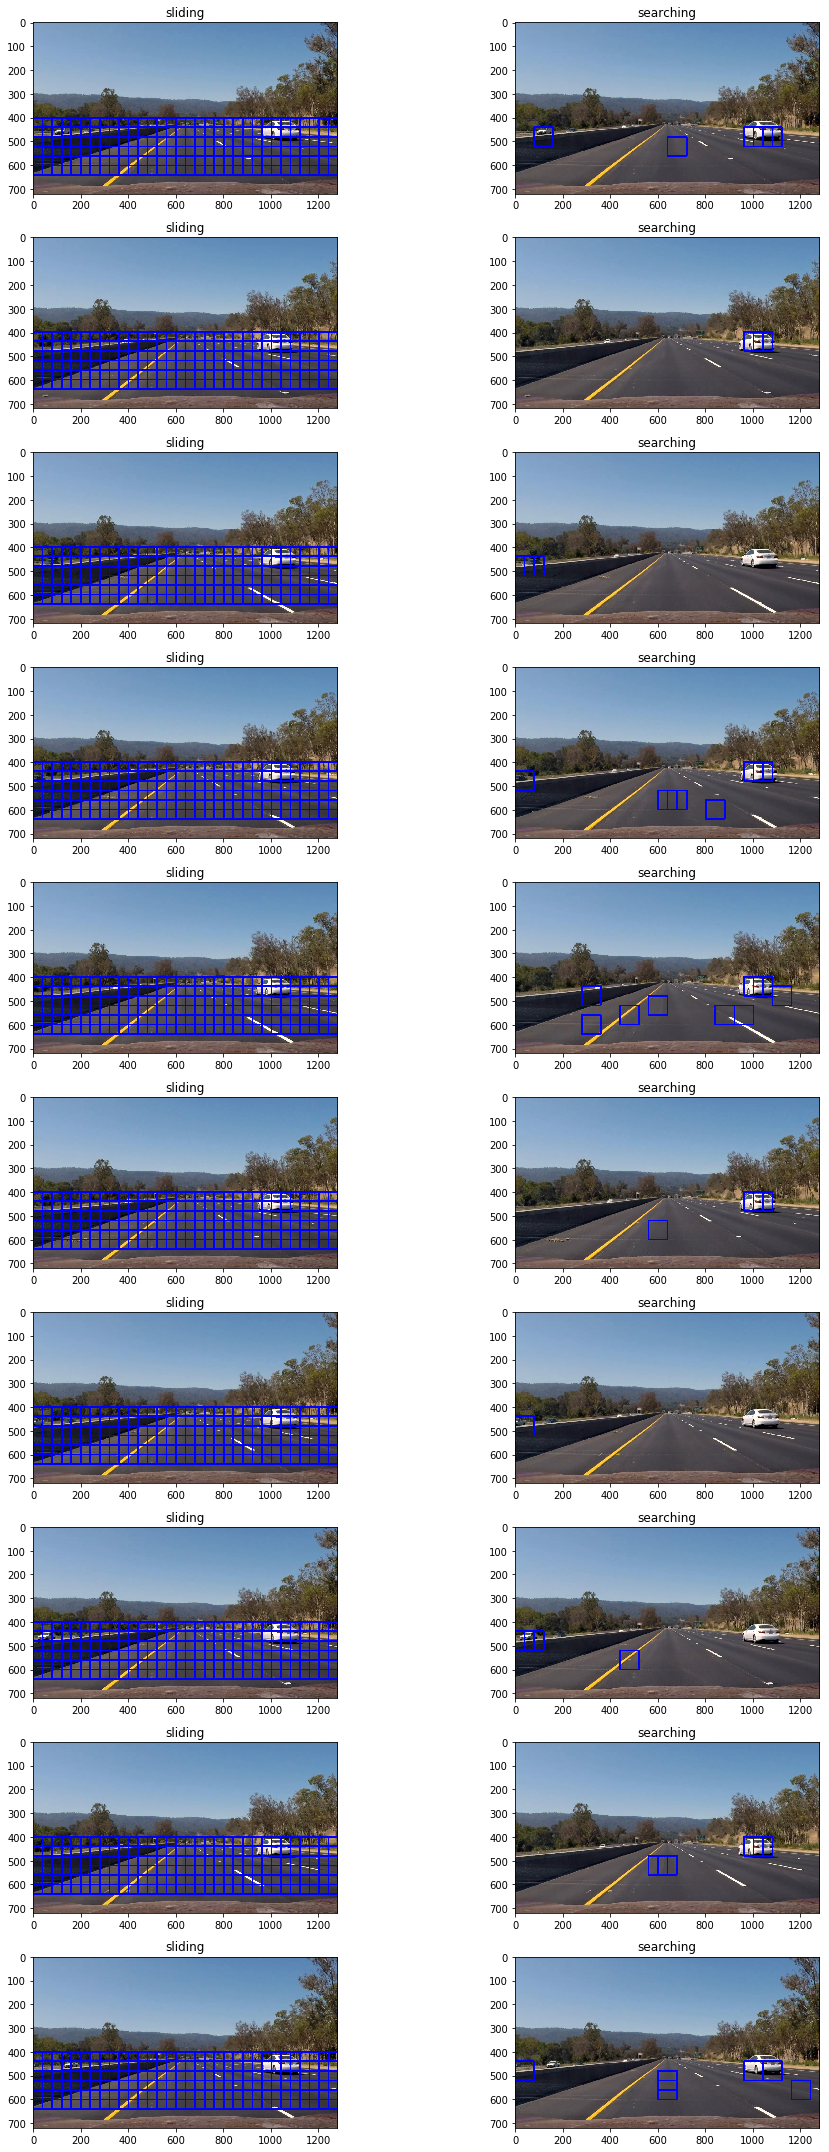

In [20]:
test_image_path = 'test_images/serial_test/'
test_images = glob.glob(test_image_path+'*.jpg')
images = []
titles = []
y_start = 400
y_stop = 656
overlap = 0.5
spatial_feat = True
hist_feat = True
hog_feat = True

for img_src in test_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    copy_img = np.copy(img)
    # Scaled image
    # Training: mpimg.imread png (0-1)
    #           cv2.imread() (0-255)
    # Using:    mpimg.imread jpg (0-255)
    img = img.astype(np.float32)/255

    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=[y_start, y_stop], 
                    xy_window=(80, 80), xy_overlap=(overlap, overlap))

    hot_windows = search_windows(img, windows, svc, X_scaler, 
                                x_start_stop=[None, None], y_start_stop=[y_start, y_stop], 
                                color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)

    sliding_img = draw_boxes(copy_img, windows, color=(0, 0, 255), thick=6)
    window_img = draw_boxes(copy_img, hot_windows, color=(0, 0, 255), thick=6)
    images.append(sliding_img)
    images.append(window_img)
    titles.append('sliding')
    titles.append('searching')
    print(time.time()-t1, 'seconds to process one image searching', len(windows), 'windows')

cv2.imwrite('output_images/sliding_windows.png', cv2.cvtColor(images[0], cv2.COLOR_RGB2BGR))
fig = plt.figure(figsize=(15,30))#, dpi=300)
visualize(fig, 10, 2, images, titles)
fig.tight_layout()
# Save to local disk
plt.savefig('output_images/sliding_window.png')

## Step 5: False Positives

### 5.1 Import library

In [21]:
from scipy.ndimage.measurements import label
from collections import deque

### 5.2 Define Functions

In [22]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels, ystart):

    global pre_bboxes
    
    is_have_car = False
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        if (np.min(nonzeroy) < ystart+40): # check ymin with offset is 1/2 window search
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            if (bbox[1][0]-bbox[0][0] >= bbox[1][1]-bbox[0][1] and
                bbox[1][0]-bbox[0][0] <= 2*bbox[1][1]-bbox[0][1]): # width >= height and width <= 2*height
                is_have_car = True

        # Update bbox base on pre frame
        if is_have_car == True:
            if len(pre_bboxes) >= car_number:
                if (abs(bbox[0][0] - pre_bboxes[car_number-1][0][0]) <= 40 and
                    abs(bbox[0][1] - pre_bboxes[car_number-1][0][1]) <= 40 and
                    abs(bbox[1][0] - pre_bboxes[car_number-1][1][0]) <= 40 and
                    abs(bbox[1][1] - pre_bboxes[car_number-1][1][1]) <= 40): # Not different too much
                    bbox = tuple(map(tuple, np.sum((pre_bboxes[car_number-1], bbox), axis=0)//2))
        else:
            '''
            if len(pre_bboxes) >= car_number:
                bbox = pre_bboxes[car_number-1]
            else:
            '''
            bbox = ((0,0),(0,0))

        if bbox != ((0,0),(0,0)):
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)

            # Update pre_frame_bbox_list
            if len(pre_bboxes) >= car_number:
                pre_bboxes[car_number-1] = bbox
            else:
                pre_bboxes.append(bbox)

        is_have_car = False # Reset for next iter

    # Return the image
    return img

def pipeline_heatmap(img, box_list, ystart):

    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    heatmap_queue.append(heat)

    # Apply threshold to help remove false positives
    heat = np.sum(heatmap_queue, dtype=np.uint8, axis=(0))
    #threshold = max(np.concatenate(heat).ravel())*0.5 # Reduce detection result to reduce noise
    threshold = len(heatmap_queue)*0.4
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels, ystart)

    return draw_img, heatmap

### 5.3 Test

0.5860822200775146 seconds to process one image searching 155 windows
0.6111867427825928 seconds to process one image searching 155 windows
0.590111494064331 seconds to process one image searching 155 windows
0.5981118679046631 seconds to process one image searching 155 windows
0.6286344528198242 seconds to process one image searching 155 windows
0.6075332164764404 seconds to process one image searching 155 windows
0.6383261680603027 seconds to process one image searching 155 windows
0.6155409812927246 seconds to process one image searching 155 windows
0.6425838470458984 seconds to process one image searching 155 windows
0.6455948352813721 seconds to process one image searching 155 windows


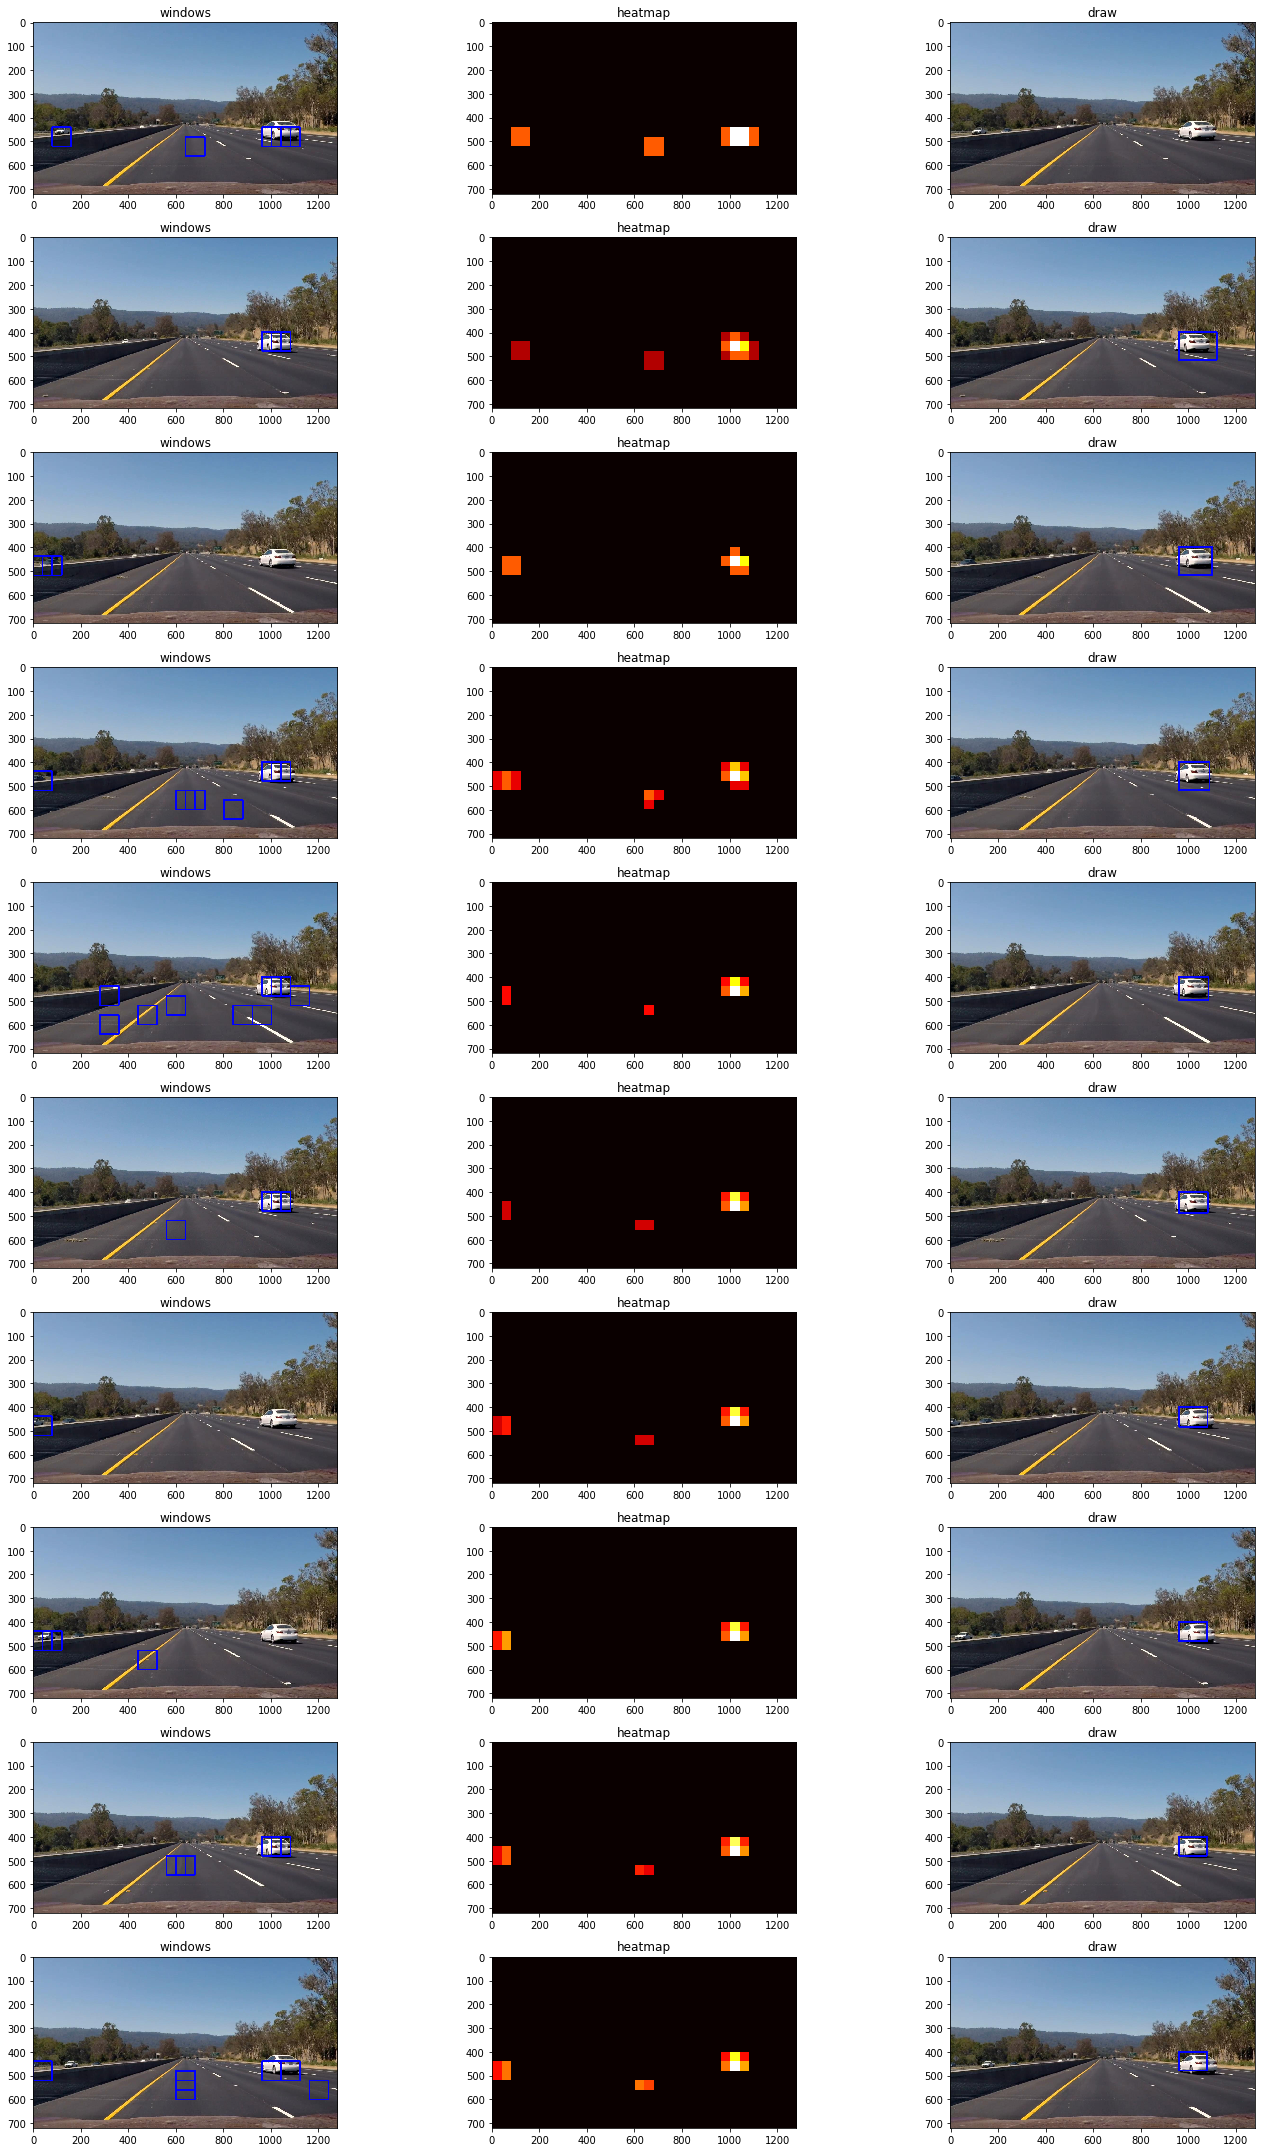

In [23]:
test_image_path = 'test_images/serial_test/'
test_images = glob.glob(test_image_path+'*.jpg')
images = []
titles = []

y_start = 400
y_stop = 656
overlap = 0.5
spatial_feat = True
hist_feat = True
hog_feat = True
heatmap_queue = deque(maxlen=10)
pre_bboxes = []

for img_src in test_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    copy_img = np.copy(img)
    img = img.astype(np.float32)/255

    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=[y_start, y_stop], 
                    xy_window=(80, 80), xy_overlap=(overlap, overlap))

    hot_windows = search_windows(img, windows, svc, X_scaler, 
                                x_start_stop=[None, None], y_start_stop=[y_start, y_stop], 
                                color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)

    window_img = draw_boxes(copy_img, hot_windows, color=(0, 0, 255), thick=6)
    draw_img, heatmap = pipeline_heatmap(copy_img, hot_windows, y_start)

    images.append(window_img)
    images.append(heatmap)
    images.append(draw_img)
    titles.append('windows')
    titles.append('heatmap')
    titles.append('draw')
    print(time.time()-t1, 'seconds to process one image searching', len(windows), 'windows')

cv2.imwrite('output_images/labels_map.png', cv2.cvtColor(images[-2]*(255//images[-2].max()), cv2.COLOR_GRAY2BGR))
cv2.imwrite('output_images/output_bboxes.png', cv2.cvtColor(images[-1], cv2.COLOR_RGB2BGR))
fig = plt.figure(figsize=(20,30))#, dpi=300)
visualize(fig, 10, 3, images, titles)
fig.tight_layout()
# Save to local disk
plt.savefig('output_images/false_positives.png')

## Step 6: Combine results

### 6.1 Import library for using PIL Image

In [24]:
from PIL import Image

### 6.2 Define functions

In [25]:
def heatmap2rgb(heatmap):
    heatmap *= (255//heatmap.max())
    cmap = plt.get_cmap('jet')
    rgba_img = cmap(heatmap)
    rgb_img = (np.delete(rgba_img, 3, 2)*255).astype('uint8')
    return rgb_img

def PIL2array(img):
    return np.array(img.getdata(),
                    np.uint8).reshape(img.size[1], img.size[0], 3)

def combine_img(child_img_1, child_img_2, parent_img, offset=20):

    img_shape = parent_img.shape
    # Create output image to add 2 child images
    output_img = Image.fromarray(parent_img)
    # Resize 2 child images before combining
    small_img_1 = cv2.resize(child_img_1, 
                             (img_shape[1]//2-2*offset, img_shape[0]//2-2*offset), 
                             interpolation=cv2.INTER_LINEAR)
    small_img_2 = cv2.resize(child_img_2, 
                             (img_shape[1]//2-2*offset, img_shape[0]//2-2*offset), 
                             interpolation=cv2.INTER_LINEAR)
    # Adding 2 child images
    output_img.paste(Image.fromarray(small_img_1), (offset, offset))
    output_img.paste(Image.fromarray(small_img_2), (img_shape[1]//2+offset, offset))

    return PIL2array(output_img)

### 6.3 Test

0.6051738262176514 seconds to process one image searching 155 windows


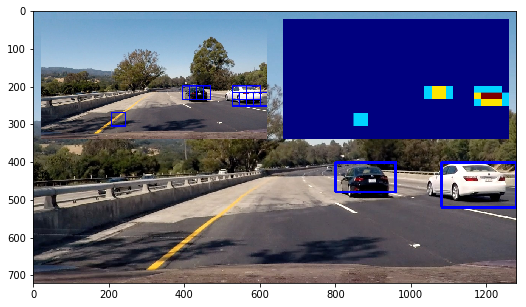

In [26]:
y_start = 400
y_stop = 656
overlap = 0.5
spatial_feat = True
hist_feat = True
hog_feat = True
heatmap_queue = deque(maxlen=10)
pre_bboxes = []

t1 = time.time()
img = mpimg.imread('test_images/test4.jpg')
copy_img = np.copy(img)
img = img.astype(np.float32)/255

windows = slide_window(img, x_start_stop=[None, None], y_start_stop=[y_start, y_stop], 
                xy_window=(80, 80), xy_overlap=(overlap, overlap))

hot_windows = search_windows(img, windows, svc, X_scaler, 
                            x_start_stop=[None, None], y_start_stop=[y_start, y_stop], 
                            color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
'''
hot_windows = ori_search_windows(img, windows, svc, X_scaler, 
                            color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
'''
window_img = draw_boxes(copy_img, hot_windows, color=(0, 0, 255), thick=6)
draw_img, heatmap = pipeline_heatmap(copy_img, hot_windows, y_start)

print(time.time()-t1, 'seconds to process one image searching', len(windows), 'windows')

out = combine_img(window_img, heatmap2rgb(heatmap), draw_img, 20)
plt.figure(figsize=(10,5))
plt.imshow(out)
# Save to local disk
plt.savefig('output_images/combining.png')

## Step 7: Tracking Pipeline

In [27]:
def process_image(img):

    copy_img = np.copy(img)
    img = img.astype(np.float32)/255

    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=[y_start, y_stop], 
                    xy_window=(80, 80), xy_overlap=(overlap, overlap))

    hot_windows = search_windows(img, windows, svc, X_scaler, 
                                x_start_stop=[None, None], y_start_stop=[y_start, y_stop], 
                                color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)

    window_img = draw_boxes(copy_img, hot_windows, color=(0, 0, 255), thick=6)
    draw_img, heatmap = pipeline_heatmap(copy_img, hot_windows, y_start)

    return combine_img(window_img, heatmap2rgb(heatmap), draw_img, 20)
    #return draw_img

## Step 8: Video Implementation

### 8.1 Import library

In [28]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### 8.2 Create Serial frame Test from Video

In [29]:
clip = VideoFileClip('project_video.mp4').subclip(15, 20)
for i in range(0, 10, 1):
    clip.save_frame('test_images/serial_test/frame_%d.jpg' %i, t=i/10)

### 8.3 Test Video

In [30]:
output_path = 'output_videos/'
video_input = 'test_video.mp4'

y_start = 400
y_stop = 656
overlap = 0.5
spatial_feat = True
hist_feat = True
hog_feat = True
heatmap_queue = deque(maxlen=10)
pre_bboxes = []

clip = VideoFileClip('test_video.mp4')
test_clip = clip.fl_image(process_image)
#%time
test_clip.write_videofile(output_path+video_input, audio=False)

[MoviePy] >>>> Building video output_videos/test_video.mp4
[MoviePy] Writing video output_videos/test_video.mp4


 97%|█████████▋| 38/39 [00:51<00:01,  1.38s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_video.mp4 



In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path+video_input))

### 8.4 Project Video

In [32]:
output_path = 'output_videos/'
video_input = 'project_video.mp4'

y_start = 400
y_stop = 656
overlap = 0.5
spatial_feat = True
hist_feat = True
hog_feat = True
heatmap_queue = deque(maxlen=10)
pre_bboxes = []

#clip = VideoFileClip('project_video.mp4').subclip(42, 44)
clip = VideoFileClip('project_video.mp4')
test_clip = clip.fl_image(process_image)
#%time
test_clip.write_videofile(output_path+video_input, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [28:53<00:01,  1.39s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 



In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path+video_input))